In [281]:
#copyright joshuah.rainstar@gmail.com
from __future__ import annotations
import math
import typing

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from typing import Dict, Tuple


class Coop5(nn.Module):
    def __init__(self):
        super().__init__()

    @staticmethod
    def _softsign(x: torch.Tensor) -> torch.Tensor:
        return x / (1.0 + x.abs())

    @staticmethod
    def _zls(x: torch.Tensor) -> torch.Tensor:
        sp = F.softplus(x)
        sa = torch.sigmoid(0.5 * x)
        ba = sa * (1.0 - sa)
        return sp - 2.77258872223978123766 * ba  # 4*ln(2)

    @staticmethod
    def forward(R: torch.Tensor, C: torch.Tensor) -> torch.Tensor:
        # Similarity gating
        w = Coop5._zls(Coop5._softsign(R * C).sum(dim=-1, keepdim=True) / (2 * R.size(-1) ** 0.5))
        # RK2-style update
        k1 = w * (C - R)
        k2 = w * (C - (R + 0.5 * k1))
        return R + 0.25 * (k1 - k2)
        
    '''#may offer better effect, but more costly
    @staticmethod
    def forward(R: torch.Tensor, C: torch.Tensor) -> torch.Tensor:
        # Similarity gating
        w = Coop5._zls(Coop5._softsign(R * C).sum(dim=-1, keepdim=True) / (2 * R.size(-1) ** 0.5))
        # RK2-style update
        k1 = w * (C - R)
        # Midpoint
        R_mid = R + 0.5 * k1
        w2 = Coop5._zls(Coop5._softsign(R_mid * C).sum(dim=-1, keepdim=True) / (2 * R.size(-1) ** 0.5))
        k2 = w2 * (C - R_mid)
        return R + 0.25 * (k1 + k2)
    '''


class DynMix(nn.Module):
    def __init__(self):
        super().__init__()
        self.coop = Coop5()

    def mix_list(self,xs):
        n = len(xs)
        stacked = torch.stack(xs, 0)
        total = stacked.sum(0)
        out = []
        for i in range(n):
            others_mean = (total - stacked[i]) / (n - 1)
            out.append(self.coop(stacked[i], others_mean))
        return out

    def forward(self, comps, loop_iters: int = 2):
        for _ in range(loop_iters):
            comps = self.mix_list(comps)
        return comps
        
class PhaseTap(nn.Module):
    """
    Phase-preserving vector shift with guarded Householder.
    x: (B,T,C) -> y: (B,T,C)
      - t < d:  y[:, t, :] = (1/(d - t)) * a
      - t >= d: y[:, t, :] = H(x_t)^T @ (x_t - x_{t-d})
    Guards:
      - near u_t ≈ a: skip reflection, use identity on v
      - near u_t ≈ -a: use fixed orthonormal b
      - near zero ||x_t||: skip reflection
    """
    def __init__(self, d: int, tau: float = 1e-6):  # ?1 tau
        super().__init__()
        assert isinstance(d, int) and d >= 1
        self.d = d
        self.tau = float(tau)

    @staticmethod
    def _norm(v: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
        return torch.linalg.vector_norm(v, dim=-1).clamp_min(eps)

    @staticmethod
    def _safe_unit(v: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
        n = torch.linalg.vector_norm(v, dim=-1, keepdim=True).clamp_min(eps)
        return v / n

    def _apply_householder_sym(self, a: torch.Tensor, u: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
        """
        Apply H v with H a = u, H = I - 2 w w^T, symmetric so H^T = H.
        a,u,v: (..., C)
        Guards near a, near -a, and near zero u.
        """
        C = a.shape[-1]
        # masks
        dot = (a * u).sum(dim=-1, keepdim=True)                      # (...,1)
        near_pos = (dot > 1.0 - self.tau).squeeze(-1)                # (...)
        near_neg = (dot < -1.0 + self.tau).squeeze(-1)               # (...)
        near_zero_u = (torch.linalg.vector_norm(u, dim=-1) < self.tau)  # (...)

        y = v.clone()

        # general case mask
        gen = ~(near_pos | near_neg | near_zero_u)
        if gen.any():
            w = self._safe_unit(a[gen] - u[gen])
            wTv = (w * v[gen]).sum(dim=-1, keepdim=True)
            y[gen] = v[gen] - 2.0 * w * wTv

        # near -a: reflect across fixed b orthonormal to a
        if near_neg.any():
            if C == 1:
                y[near_neg] = -v[near_neg]
            else:
                b = torch.zeros_like(a[near_neg])
                b[..., 1] = 1.0
                bbT_v = (b * v[near_neg]).sum(dim=-1, keepdim=True)
                y[near_neg] = v[near_neg] - 2.0 * b * bbT_v

        # near +a or near zero u: identity on v
        # y[near_pos] and y[near_zero_u] already equal v by init

        return y

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 3, "x must be (B,T,C)"
        B, T, C = x.shape
        device = x.device
        dtype = x.dtype

        y = torch.zeros_like(x)

        # anchor a = e0
        a = torch.zeros(B, 1, C, device=device, dtype=dtype)
        a[..., 0] = 1.0

        # early baseline
        if self.d > 0:
            t_idx = torch.arange(T, device=device)
            early_mask = t_idx < self.d
            if early_mask.any():
                denom = (self.d - t_idx[early_mask]).to(dtype=dtype)
                y[:, early_mask, :] = a.expand(B, early_mask.sum(), C) * denom.unsqueeze(0).reciprocal().unsqueeze(-1)

        if T <= self.d:
            return y

        # main region
        x_t  = x[:, self.d:, :]          # (B,T-d,C)
        x_tm = x[:, :-self.d, :]         # (B,T-d,C)
        u_t  = self._safe_unit(x_t)      # (B,T-d,C)

        a_bt = a.expand(B, x_t.shape[1], C)
        v    = x_t - x_tm

        if C == 1:
            y[:, self.d:, :] = v
            return y

        y[:, self.d:, :] = self._apply_householder_sym(a_bt, u_t, v)
        return y
        
class PhaseTransport(nn.Module):
    def __init__(self, d: int, tau: float = 1e-6):
        super().__init__()
        assert isinstance(d, int) and d >= 1
        self.d = d
        self.tau = float(tau)

    @staticmethod
    def _norm(v: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
        return torch.linalg.vector_norm(v, dim=-1).clamp_min(eps)

    @staticmethod
    def _safe_unit(v: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
        n = torch.linalg.vector_norm(v, dim=-1, keepdim=True).clamp_min(eps)
        return v / n

    @staticmethod
    def _orthonormal_perp(v: torch.Tensor) -> torch.Tensor:
        # v: (N, C) assumed nonzero
        N, C = v.shape
        idx = torch.argmin(torch.abs(v), dim=-1)      # pick coord with smallest magnitude
        e = torch.zeros_like(v)
        e.scatter_(1, idx.unsqueeze(1), 1.0)
        p = e - (e * v).sum(dim=-1, keepdim=True) * v # Gram-Schmidt
        p = p / PhaseTransport._norm(p).unsqueeze(-1)
        return p

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 3, "x must be (B,T,C)"
        B, T, C = x.shape
        device, dtype = x.device, x.dtype
        y = torch.zeros_like(x)

        # early baseline with per-sequence direction, not a global axis
        if T > 0:
            ref_t = min(self.d, T - 1)
            u_ref = self._safe_unit(x[:, ref_t, :])  # (B, C)
            if self.d > 0:
                t_idx = torch.arange(T, device=device)
                early_mask = t_idx < self.d
                if early_mask.any():
                    denom = (self.d - t_idx[early_mask]).to(dtype=dtype)     # (Te,)
                    scales = (1.0 / denom).view(1, -1, 1)                    # (1, Te, 1)
                    y[:, early_mask, :] = u_ref.view(B, 1, C) * scales       # (B, Te, C)

        if T <= self.d:
            return y

        # main region t >= d
        xt  = x[:, self.d:, :]             # (B, T-d, C)
        xtm = x[:, :-self.d, :]            # (B, T-d, C)
        u   = self._safe_unit(xt)          # (B, T-d, C)
        v   = self._safe_unit(xtm)         # (B, T-d, C)
        w   = xt - xtm                      # (B, T-d, C)

        c = (u * v).sum(dim=-1, keepdim=True)          # (B, T-d, 1)
        # squeeze masks to (B, T-d)
        near_pos = (c > 1.0 - self.tau).squeeze(-1)
        near_neg = (c < -1.0 + self.tau).squeeze(-1)
        small_u  = (torch.linalg.vector_norm(xt,  dim=-1) < self.tau)
        small_v  = (torch.linalg.vector_norm(xtm, dim=-1) < self.tau)
        trivial  = near_pos | small_u | small_v

        y_main = w.clone()

        # general case
        gen = ~(trivial | near_neg)
        if gen.any():
            u_g = u[gen]                       # (N, C)
            v_g = v[gen]
            w_g = w[gen]
            c_g = c[gen].unsqueeze(-1)[:, 0, :]  # (N, 1) ensure 2D
            alpha = 1.0 / (1.0 + c_g)          # (N, 1)

            a = (v_g * w_g).sum(dim=-1, keepdim=True)  # v·w
            b = (u_g * w_g).sum(dim=-1, keepdim=True)  # u·w
            Kw  = u_g * a - v_g * b
            K2w = u_g * (a * c_g - b) + v_g * (b * c_g - a)
            y_main[gen] = w_g - Kw + alpha * K2w

        # antipodal 180 deg
        if near_neg.any():
            v_n = v[near_neg]                 # (N, C)
            w_n = w[near_neg]
            p   = self._orthonormal_perp(v_n) # (N, C)
            proj_v = (v_n * w_n).sum(dim=-1, keepdim=True) * v_n
            proj_p = (p   * w_n).sum(dim=-1, keepdim=True) * p
            y_main[near_neg] = w_n - 2.0 * proj_v - 2.0 * proj_p

        y[:, self.d:, :] = y_main
        return y



import math
import torch
import torch.nn as nn
from typing import List, Tuple

# ---------------------------
# small number utils
# ---------------------------

def is_prime(n: int) -> bool:
    if n < 2: return False
    if n % 2 == 0: return n == 2
    r = int(n ** 0.5)
    f = 3
    while f <= r:
        if n % f == 0: return False
        f += 2
    return True

def first_primes(k: int, start: int = 3) -> List[int]:
    out, p = [], max(3, start | 1)
    while len(out) < k:
        if is_prime(p): out.append(p)
        p += 2
    return out

def inv_mod(a: int, m: int) -> int:
    # Extended Euclid
    t, new_t, r, new_r = 0, 1, m, a % m
    while new_r != 0:
        q = r // new_r
        t, new_t = new_t, t - q * new_t
        r, new_r = new_r, r - q * new_r
    if r != 1:
        raise ValueError("a not invertible mod m")
    return t % m

def crt_pair(r1: int, m1: int, r2: int, m2: int) -> Tuple[int, int]:
    """
    Solve x ≡ r1 (mod m1), x ≡ r2 (mod m2).
    Returns (x in [0, m1*m2), modulus = m1*m2).
    Assumes m1 and m2 are coprime.
    """
    t = ((r2 - r1) % m2) * inv_mod(m1 % m2, m2) % m2
    x = r1 + m1 * t
    M = m1 * m2
    return x % M, M

# ---------------------------
# modulo hash head
# ---------------------------

class ModuloHash(nn.Module):
    """
    f(x): R^D -> residues r_k in Z_{m_k}
    Steps per channel k:
      s_k = a_k^T x + b_k
      f_k = s_k mod T_k  (fold)
      q_k = round( m_k * f_k / T_k ) mod m_k  (round-off to nearest bin)
    """
    def __init__(
        self,
        D: int,
        moduli: List[int],
        seed: int = 0,
    ):
        super().__init__()
        self.D = D
        self.m = torch.tensor(moduli, dtype=torch.long)  # [K]
        self.K = len(moduli)

        g = torch.Generator().manual_seed(seed)
        W = torch.randn(D, self.K, generator=g) / math.sqrt(D)
        b = torch.randn(self.K, generator=g) * 0.01
        T = torch.ones(self.K)  # periods; start at 1.0
        self.register_buffer("W", W)
        self.register_buffer("b", b)
        self.register_buffer("T", T)


    def periods(self) -> torch.Tensor:
        return self.T

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, D]
        s = x @ self.W + self.b  # [B, K]
        T = self.periods()       # [K]
        # fold to [0, T)
        f = torch.remainder(s, T)  # [B, K]
        # map to bins [0, m_k)
        m = self.m.to(f.device).to(torch.float32)
        r_float = f * (m / T)                 # [B, K]
        q = torch.floor(r_float + 0.5)        # nearest bin
        q = torch.remainder(q, m)             # wrap edges
        return q.to(torch.long)               # [B, K]

# ---------------------------
# experts
# ---------------------------

class RowWiseExpertsMLP(nn.Module):
    def __init__(self, D: int, H1: int, O: int, E: int):
        super().__init__()
        self.D, self.H1, self.O, self.E = D, H1, O, E
        self.W1 = nn.Parameter(torch.zeros(E, H1, D))
        torch.nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')
        self.W2 = nn.Parameter(torch.zeros(E, O,  H1) )
        torch.nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')
        self.b2 = nn.Parameter(torch.zeros(E, O))

    def forward(self, x: torch.Tensor, eid: torch.Tensor) -> torch.Tensor:
        B = x.size(0)
        device = x.device
    
        eid_sorted, idx_sort = torch.sort(eid)         # [B]
        x_sorted = x.index_select(0, idx_sort)         # [B, D]
        Y_sorted = torch.empty(B, self.O, device=device, dtype=x.dtype)
    
        for e in range(self.E):
            idx_e = (eid_sorted == e).nonzero(as_tuple=False).squeeze(1)  # [n]
            if idx_e.numel() == 0:
                continue
            X_e = x_sorted.index_select(0, idx_e)                         # [n, D]
            H_e = X_e.matmul(self.W1[e].t())
            H_e = F.gelu(H_e)
            Y_e = H_e.matmul(self.W2[e].t()).add_(self.b2[e])
            Y_sorted.index_copy_(0, idx_e, Y_e)
    
        Y = torch.empty_like(Y_sorted)
        Y[idx_sort] = Y_sorted
        return Y

# ---------------------------
# router with CRT consensus
# ---------------------------

class ModCRTMoE(nn.Module):
    """
    Hard router:
      1) ModuloHash -> residues r_k in Z_{m_k}
      2) Build CRT candidates from all channel pairs
      3) Pick candidate with maximum residue agreement
      4) expert_id = candidate % E
      5) Send raw x to that expert
    """
    def __init__(
        self,
        D: int,
        num_experts: int,
        moduli: List[int] = None,
        seed: int = 0,
    ):
        super().__init__()
        self.D, self.O, self.E = D, D*2, num_experts

        # choose pairwise coprime moduli; default primes until product >= 4E
        if moduli is None:
            K = 3
            while True:
                primes = first_primes(K)
                prod = 1
                for p in primes: prod *= p
                if prod >= max(4 * num_experts, 256):
                    moduli = primes
                    break
                K += 1

        # sanity: pairwise coprime
        for i in range(len(moduli)):
            for j in range(i + 1, len(moduli)):
                if math.gcd(moduli[i], moduli[j]) != 1:
                    raise ValueError("moduli must be pairwise coprime")

        self.moduli = moduli
        self.hash = ModuloHash(D, moduli, seed=seed)

        # precompute pairwise inverses for speed
        K = len(moduli)
        self._pair_idx = []
        self._pair_data = []
        for i in range(K):
            for j in range(i + 1, K):
                m1, m2 = moduli[i], moduli[j]
                inv = inv_mod(m1 % m2, m2)
                self._pair_idx.append((i, j))
                self._pair_data.append((m1, m2, inv))

        # experts
        self.experts = RowWiseExpertsMLP(D, D*2, D,num_experts)

    @torch.no_grad()
    def _crt_pair_batched(self, r: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        r: [B, K] residues
        returns:
          cand: [B, P] candidate integers
          modP: [P] corresponding moduli products
        """
        B, K = r.shape
        P = len(self._pair_idx)
        cand = torch.empty(B, P, dtype=torch.long, device=r.device)
        modP = torch.empty(P, dtype=torch.long, device=r.device)
        for p, ((i, j), (m1, m2, inv)) in enumerate(zip(self._pair_idx, self._pair_data)):
            r1 = r[:, i]
            r2 = r[:, j]
            # t = ((r2 - r1) mod m2) * inv mod m2
            t = ((r2 - r1) % m2) * inv % m2
            x = r1 + t * m1
            cand[:, p] = x % (m1 * m2)
            modP[p] = m1 * m2
        return cand, modP

    @torch.no_grad()
    def _consensus_pick(self, r: torch.Tensor, cand: torch.Tensor, modP: torch.Tensor) -> torch.Tensor:
        """
        r: [B, K] residues
        cand: [B, P] candidate integers
        modP: [P]
        returns: best candidate per row in [0, inf), then reduced mod E
        """
        B, K = r.shape
        P = cand.shape[1]
        m = torch.tensor(self.moduli, dtype=torch.long, device=r.device)  # [K]
        # expand for vectorized residue checks
        # For each candidate c and each channel k, check if c % m_k == r_k
        c_exp = cand.unsqueeze(-1)  # [B, P, 1]
        m_exp = m.view(1, 1, K)     # [1, 1, K]
        r_exp = r.unsqueeze(1)      # [B, 1, K]
        match = (c_exp % m_exp) == r_exp  # [B, P, K]
        scores = match.sum(dim=-1)        # [B, P]
        # pick argmax
        best_idx = torch.argmax(scores, dim=1)  # [B]
        best = cand[torch.arange(B, device=r.device), best_idx]  # [B]
        return best % self.E

    @torch.no_grad()
    def route(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Accept x of shape [B, D] or [B, T, D].
        Returns:
          expert_ids: [B] or [B, T]
          residues:   [B, K] or [B, T, K]
        """
        if x.ndim == 2:
            B, D = x.shape
            x_flat = x
            shape_info = ("2d", B, 1, D)
        elif x.ndim == 3:
            B, T, D = x.shape
            x_flat = x.reshape(B*T, D)
            shape_info = ("3d", B, T, D)
        else:
            raise ValueError("x must be [B, D] or [B, T, D]")

        residues_flat = self.hash(x_flat)          # [N, K] with N=B or B*T
        cand, modP = self._crt_pair_batched(residues_flat)   # uses [N, K]
        eid_flat = self._consensus_pick(residues_flat, cand, modP)  # [N]

        kind, B, T, _ = shape_info
        if kind == "2d":
            return eid_flat, residues_flat  # [B], [B, K]
        else:
            K = residues_flat.size(-1)
            return eid_flat.view(B, T), residues_flat.view(B, T, K)  # [B, T], [B, T, K]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, D] or [B, T, D]
        if x.ndim == 2:
            with torch.no_grad():
                eid, _ = self.route(x)        # [B]
            y = self.experts(x, eid)          # [B, D]
            return y
        elif x.ndim == 3:
            B, T, D = x.shape
            x_flat = x.reshape(B*T, D)
            with torch.no_grad():
                eid, _ = self.route(x)        # [B, T]
            y_flat = self.experts(x_flat, eid.view(-1))  # [B*T, D]
            return y_flat.view(B, T, D)
        else:
            raise ValueError("x must be [B, D] or [B, T, D]")
        



class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)


"""
Manifold Attention (no learned attention) with deterministic subspace iteration.

Core idea
---------
Treat X in [B, T, D] as a curve in R^D over time. Build a compact, self-adjoint
operator C = (1/T) X'^T X' with X' = X - anchor + low_rank_shift(X). Extract a
rank-r invariant subspace with K steps of deterministic subspace iteration.
Project onto that basis to obtain r scalar traces, apply simple analytic
conditioning (energy normalization and optional soft shrinkage, optional causal
AR(1)), then reconstruct with the (orthonormal) basis and undo the shift. No
query-key-value attention, no near/far field.

Notes
-----
- Subspace iteration is deterministic and differentiable. We use batched QR to
  orthonormalize after each step. K controls the number of power iterations.
  If you want K to play the role of "heads", think of each iteration as a head
  that sharpens alignment to the top-r invariant subspace. In practice we use
  the final V_K for projection.
- Low-rank shift S(X) = U sigma(V^T X) is optional and helps undo harmful
  normalization. Set bottleneck "shift_rank" to 0 to disable.
- The basis columns are sign-aligned to the first token so that they are stable
  across steps and batches.
- Reconstruction uses V^T directly since columns are orthonormal. If you swap
  orthonorm for another routine, you can still use a tiny r x r solve.

API
---
class ManifoldAttentionNoAttn(nn.Module):
    def __init__(self, d_model, rank, K=2, shift_rank=0, shrink_lambda=0.0,
                 causal=False, ar_rho=0.0, eps=1e-5, dropout=0.0):
        ...
    def forward(self, x):  # x: [B, T, D]
        return y  # [B, T, D]

Example
-------
>>> import torch
>>> B, T, D = 2, 1024, 768
>>> layer = ManifoldAttentionNoAttn(d_model=D, rank=32, K=3, shift_rank=16,
...                                 shrink_lambda=0.01, causal=False)
>>> x = torch.randn(B, T, D)
>>> y = layer(x)
>>> y.shape
torch.Size([2, 1024, 768])
"""

from typing import Optional, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F


def _batch_eye(n: int, batch: int, device: torch.device, dtype: torch.dtype) -> torch.Tensor:
    """Batched identity [B, n, n]."""
    I = torch.eye(n, device=device, dtype=dtype)
    return I.unsqueeze(0).expand(batch, n, n)


def orthonorm_columns(V: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """Orthonormalize columns of V with batched QR.

    V: [B, D, r]  -> returns Q: [B, D, r] with Q^T Q = I_r
    """
    # torch.linalg.qr supports batched input
    Q, R = torch.linalg.qr(V, mode="reduced")
    # Ensure a consistent sign by forcing diag(R) positive where possible
    diag = torch.diagonal(R, dim1=-2, dim2=-1)
    sgn = torch.sign(diag + eps).unsqueeze(-2)  # [B, 1, r]
    Q = Q * sgn
    return Q


def subspace_iteration(C: torch.Tensor, r: int, K: int, V0: Optional[torch.Tensor] = None,
                       eps: float = 1e-6) -> torch.Tensor:
    """Deterministic batched subspace iteration to approximate the top-r invariant subspace.

    C:  [B, D, D], self-adjoint, positive semi-definite (empirical covariance)
    r:  target rank (number of basis vectors)
    K:  number of power iteration steps (>= 1)
    V0: optional initial subspace [B, D, r]. If None, use the first r standard basis vectors.
    returns V_K: [B, D, r] with orthonormal columns.
    """
    B, D, _ = C.shape
    device, dtype = C.device, C.dtype

    if V0 is None:
        # Deterministic fixed init: first r columns of identity, broadcast across batch
        E = torch.zeros(D, r, device=device, dtype=dtype)
        E[:r, :r] = torch.eye(r, device=device, dtype=dtype)
        V = E.unsqueeze(0).expand(B, D, r).contiguous()
    else:
        V = V0

    V = orthonorm_columns(V, eps=eps)
    for _ in range(max(1, K)):
        V = torch.matmul(C, V)          # [B, D, D] x [B, D, r] -> [B, D, r]
        V = orthonorm_columns(V, eps=eps)
    return V


def sign_align(V: torch.Tensor, a: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """Align signs of columns of V so that v_i^T a >= 0 for each i.

    V: [B, D, r]
    a: [B, D]  (anchor token x_1)
    returns V with column-wise signs adjusted deterministically.
    """
    # Compute dot products per column: [B, r]
    dots = (V * a.unsqueeze(-1)).sum(dim=1)
    sgn = torch.sign(dots + eps)  # +eps to avoid 0 sign
    return V * sgn.unsqueeze(1)


def energy_normalize(traces: torch.Tensor, eps: float = 1e-8) -> Tuple[torch.Tensor, torch.Tensor]:
    """Per-component energy normalization over time.

    traces: [B, T, r]
    returns (normed_traces, scales) where scales: [B, 1, r]
    """
    # Energy per component across time
    scales = torch.sqrt(torch.clamp((traces**2).sum(dim=1, keepdim=True), min=0.0) + eps)
    traces_n = traces / scales
    return traces_n, scales


def soft_shrink(x: torch.Tensor, lam: float) -> torch.Tensor:
    if lam <= 0.0:
        return x
    # Elementwise soft threshold
    return torch.sign(x) * F.relu(torch.abs(x) - lam)


def ar1_filter(x: torch.Tensor, rho: float) -> torch.Tensor:
    """Causal AR(1) smoothing along time dimension for each component independently.

    x: [B, T, r], rho in [0,1)
    returns y of same shape
    """
    if rho <= 0.0:
        return x
    B, T, r = x.shape
    y = torch.zeros_like(x)
    y[:, 0, :] = x[:, 0, :]
    for t in range(1, T):
        y[:, t, :] = rho * y[:, t - 1, :] + (1.0 - rho) * x[:, t, :]
    return y


class LowRankShift(nn.Module):
    """Low-rank residual shift S(X) = U sigma(V^T X) applied per time step.

    If shift_rank == 0, the caller should bypass this module.
    """

    def __init__(self, d_model: int, shift_rank: int):
        super().__init__()
        self.d_model = d_model
        self.shift_rank = shift_rank
        self.in_proj = nn.Linear(d_model, shift_rank, bias=False)
        self.out_proj = nn.Linear(shift_rank, d_model, bias=False)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, T, D]
        z = self.in_proj(x)
        z = self.act(z)
        s = self.out_proj(z)
        return s


class ManifoldAttentionNoAttn(nn.Module):
    """Manifold Attention block without learned attention.

    - Deterministic subspace iteration with K steps to find a rank-r basis.
    - Optional low-rank shift to undo harmful normalization.
    - Analytic per-component processing: energy normalization, soft shrinkage, optional causal AR(1).
    - Reconstruction via orthonormal basis, inverse shift, anchor add-back, and residual projection.
    """

    def __init__(
        self,
        d_model: int,
        rank: int,
        K: int = 2,
        shift_rank: int = 0,
        shrink_lambda: float = 0.0,
        causal: bool = False,
        ar_rho: float = 0.0,
        eps: float = 1e-5,
        dropout: float = 0.0,
        use_layernorm: bool = True,
    ) -> None:
        super().__init__()
        assert rank > 0 and K >= 1
        self.d_model = d_model
        self.rank = rank
        self.K = K
        self.shift_rank = shift_rank
        self.shrink_lambda = float(shrink_lambda)
        self.causal = bool(causal)
        self.ar_rho = float(ar_rho)
        self.eps = float(eps)

        self.shift = LowRankShift(d_model, shift_rank) if shift_rank > 0 else None
        self.out = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(d_model) if use_layernorm else nn.Identity()
        self.dynmix = DynMix()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """x: [B, T, D] -> y: [B, T, D]"""
        B, T, D = x.shape
        assert D == self.d_model

        # Anchor at t=0 (first token)
        a = torch.zeros(B, 1, D, device=x.device, dtype=x.dtype)
        a[..., 0] = 1.0
        xc = x - a       # centered curve

        # Optional low-rank de-normalization shift
        s = self.shift(x) if self.shift is not None else torch.zeros_like(x)
        xprime = xc + s

        # Empirical covariance C = (1/T) X'^T X' + eps I
        # Shapes: X'^T @ X' -> [B, D, D]
        xt = xprime.transpose(1, 2)                       # [B, D, T]
        C = torch.matmul(xt, xprime) / float(T)           # [B, D, D]
        C = C + self.eps * _batch_eye(D, B, x.device, x.dtype)

        # Subspace iteration to get V in [B, D, r]
        V = subspace_iteration(C, self.rank, self.K, V0=None, eps=self.eps)

        # Sign alignment using anchor token a
        V = sign_align(V, a.squeeze(1))  # [B, D, r]

        # Project to r scalar traces over time: [B, T, r]
        traces = torch.matmul(xprime, V)  # [B, T, r]

        # Analytic conditioning: energy norm -> shrink -> optional AR
        traces_n, scales = energy_normalize(traces, eps=self.eps)
        traces_n = soft_shrink(traces_n, self.shrink_lambda)
        traces_list = [traces_n[..., i] for i in range(traces_n.size(-1))]

        # run your mixer
        prod = self.dynmix(traces_list)

        # stack back to [B, T, r]
        traces_n = torch.stack(prod, dim=-1)
        if self.causal and self.ar_rho > 0.0:
            traces_n = ar1_filter(traces_n, self.ar_rho)
        traces_final = traces_n * scales  # restore per-component scale

        # Recompose: X_tilde = traces_final @ V^T
        x_tilde = torch.matmul(traces_final, V.transpose(1, 2))  # [B, T, D]

        # Undo shift and add anchor
        x_hat = x_tilde - s + a

        # Residual + thin output projection and optional norm
        y = x + self.dropout(self.out(x_hat))
        y = self.ln(y)
        return y

'''
# Quick self test
if __name__ == "__main__":
    torch.manual_seed(0)
    B, T, D = 2, 256, 128
    x = torch.randn(B, T, D)

    layer = ManifoldAttentionNoAttn(
        d_model=D,
        rank=16,
        K=3,                # K controls subspace iteration depth; think of it as spectral head count
        shift_rank=8,       # set 0 to disable shift
        shrink_lambda=0.01, # 0.0 to disable shrink
        causal=False,
        ar_rho=0.0,
        eps=1e-5,
        dropout=0.1,
        use_layernorm=True,
    )

    y = layer(x)
    print("Input:", x.shape, "Output:", y.shape)
'''

    
    
class BlockFast(nn.Module):
    def __init__(self, config,d):
        super().__init__()
        self.encode  = ModCRTMoE(config.n_embd,8)
        self.distance_encoder_learned = PhaseTransport(d)
        self.ln = LayerNorm(config.n_embd,False)
        self.convolve  = ManifoldAttentionNoAttn(
        d_model=config.n_embd,
        rank=16,
        K=3,                # K controls subspace iteration depth; think of it as spectral head count
        shift_rank=8,       # set 0 to disable shift
        shrink_lambda=0.01, # 0.0 to disable shrink
        causal=False,
        ar_rho=0.0,
        eps=1e-5,
        dropout=0.1,
        use_layernorm=True,
    )
    def forward(self, x):
        B,T,C= x.shape
        x = self.ln(x)
        a = self.distance_encoder_learned(x)
        a = self.convolve(a)
        a =  self.encode(a)

        return a

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 66 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_embd: int = 128
    n_head:int = 8
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        self.n_embd = config.n_embd

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            h = nn.ModuleList([BlockFast(config,1) for i in range(config.n_layer)]),


        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # tie weights
        self.lm_head.weight = self.transformer.wte.weight

    # ---------- forward ----------
    def forward(self, idx, targets=None, eprint=False):
        device = idx.device
        b, t = idx.size()
        x = self.transformer.wte(idx)
        for i in range(self.config.n_layer):
            x= x + self.transformer.h[i](x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1),
                ignore_index=-1
            )
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None
        return logits, loss

In [282]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...


KeyboardInterrupt: 

In [167]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,#"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [283]:
config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=12,
    n_embd=64,
    n_head=4,
    block_size=block_size
)

model = GPT(config)

model = model.to(device)

In [284]:
# import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap edata (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )

train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)





In [285]:
    total_params = sum(param.numel() for param in model.parameters())
    print(f"Total parameters: {total_params}")

Total parameters: 1646976


In [286]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []
def train_epoch():
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()

          logits, loss = model(xb, yb)
          loss = loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

61.49968338012695
57.95058059692383
54.542057037353516
51.236541748046875
46.929412841796875
43.00239944458008
40.99535369873047
39.45397186279297
36.69060134887695
34.28059387207031
32.02684783935547
28.20985221862793
25.6895809173584
21.208646774291992
19.583059310913086
18.04353141784668
16.20219612121582
15.000470161437988
14.631134986877441
13.774438858032227
11.91158676147461
11.485723495483398
10.205423355102539
9.153133392333984
8.234785079956055
7.777007102966309
8.281624794006348
7.259857654571533
6.598811149597168
6.080397605895996
5.500430107116699
6.067838668823242
5.3877129554748535
4.935970306396484
4.90904426574707
4.847694396972656
4.713160991668701
4.378579616546631
4.322312355041504
4.1150221824646
3.846430778503418
4.102788925170898
3.682168483734131
3.6594555377960205
3.5701918601989746
3.509225606918335
3.446747303009033
3.363192081451416
3.3062498569488525
3.1704866886138916
3.2356619834899902
3.2042057514190674
3.3727967739105225
3.1026148796081543
2.96306300163

KeyboardInterrupt: 

In [219]:
# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

2.337977409362793
2.2318332195281982
2.2931525707244873
2.304070234298706
2.30713152885437
2.3687472343444824
2.36645245552063
2.3023431301116943
2.414747476577759
2.2810261249542236
2.3724799156188965
2.336524724960327
2.3559298515319824
2.394416570663452
2.3908753395080566
2.3899006843566895
2.3704681396484375
2.3581650257110596
2.326561212539673
2.361502170562744
2.3558101654052734
2.311666965484619
2.3931427001953125
2.349374532699585
2.3428337574005127
2.3611013889312744
2.350295066833496
2.351344585418701
2.3640129566192627
2.3042385578155518
2.4080398082733154
2.3109142780303955
2.3477468490600586
2.3733255863189697
2.3268909454345703
2.3908846378326416
2.3745434284210205
2.364431619644165
2.4024734497070312
2.4242451190948486
2.3879737854003906
2.380390167236328
2.3404664993286133
2.346912145614624
2.3631224632263184
2.3418970108032227
2.345449686050415
2.3619251251220703
2.323265790939331
2.3977103233337402
2.3632049560546875
2.3929312229156494
2.3546531200408936
2.48279333114

KeyboardInterrupt: 

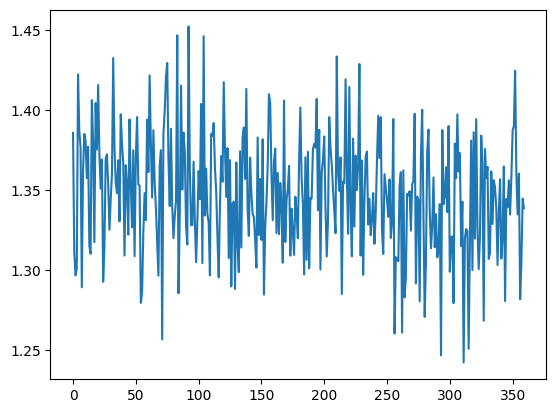

In [201]:
from matplotlib import pyplot as plt
plt.plot(losses[-360:])
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UnigramModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # learnable logits for each vocab item, no context
        self.logits = nn.Parameter(torch.zeros(vocab_size))

    def forward(self, idx, targets=None):
        if idx.ndim == 3:
            B1, B2, T = idx.shape
            B = B1 * B2
            idx = idx.reshape(B, T)
            if targets is not None:
                targets = targets.reshape(B, T)
        elif idx.ndim == 2:
            B, T = idx.shape
        else:
            raise ValueError(f"Unexpected idx shape: {idx.shape}")
    
        logits = self.logits.expand(B, T, -1)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                targets.reshape(-1),
                ignore_index=-1
            )
        return logits, loss


In [ ]:
CEmodel = UnigramModel(vocab_size).to(device)

# evaluate on validation
for X, Y in val_loader:  # build a DataLoader for val_ids
    _, loss = CEmodel(X, targets=Y)
    print("CE (nats):", loss.item())
    print("BPC:", loss.item() / torch.log(torch.tensor(2.0)))
    print("PPL:", torch.exp(loss).item())
    break

In [171]:
import numpy as np
import torch
import torch.nn.functional as F

@torch.no_grad()
def eval_bits_per_char(model, val_ids, block_size=1024, max_batches=200, device=None):
    """
    Computes BPC and PPL on random contiguous slices.
    Assumes ?1 the loss returned by model(x, y) is mean NLL per token.
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    total_nll_nat = 0.0
    total_tokens = 0

    for _ in range(max_batches):
        if len(val_ids) <= block_size + 1:
            break

        start = np.random.randint(0, len(val_ids) - block_size - 1)
        x = torch.tensor(val_ids[start:start+block_size], dtype=torch.long, device=device)[None, :]
        y = torch.tensor(val_ids[start+1:start+block_size+1], dtype=torch.long, device=device)[None, :]

        # IMPORTANT: pass y so the model returns a sequence loss
        logits, loss = model(x, y)

        # If model doesn’t return loss for some reason, compute it safely
        if loss is None:
            # Handle both possible logits shapes
            if logits.dim() == 3 and logits.size(1) == x.size(1):
                # full sequence logits [B, T, V]
                B, T, V = logits.shape
                ce = F.cross_entropy(logits.view(-1, V), y.view(-1), reduction="mean")
                nll_nat = ce.item()
                tokens = T * B
            elif logits.dim() == 2:
                # last-step logits [B, V] -> only evaluate the last target
                ce = F.cross_entropy(logits, y[:, -1], reduction="mean")
                nll_nat = ce.item()
                tokens = logits.size(0)  # B tokens (here 1)
            else:
                raise ValueError(f"Unexpected logits shape: {tuple(logits.shape)}")
        else:
            # ?1 assume this is mean NLL per token (standard)
            nll_nat = float(loss.item())
            tokens = x.numel()  # B * T

        total_nll_nat += nll_nat * tokens
        total_tokens  += tokens

    if total_tokens == 0:
        return float("nan"), float("nan")

    avg_nll_nat = total_nll_nat / total_tokens
    bpc = avg_nll_nat / np.log(2.0)
    ppl = float(np.exp(avg_nll_nat))
    return bpc, ppl

bpc, ppl = eval_bits_per_char(model, val_ids, block_size=2048, max_batches=200, device=device)
print("BPC:", bpc, "Perplexity:", ppl)


BPC: 2.588494471851154 Perplexity: 6.01470705036044


## '''
Negative log-likelihood (NLL): The metric underneath both BPC and PPL is the average negative log probability assigned to the true next token. Lower NLL means the model is assigning higher probability to correct targets → better performance.

BPC = NLL in bits per token. Lower BPC means fewer bits are needed to encode the text, i.e. the model compresses language better. A perfect model would reach 0.0 BPC.

PPL = exp(NLL). It represents the "effective branching factor" (how many equally likely next tokens the model is as uncertain between). Lower perplexity means the model is more confident and accurate. A perfect model would reach 1.0 PPL.'
'''
#Models with <100k parameters usually collapse to gibberish or never beat 5-gram.
#BPC of NGRAM is ~3.5-4

In [ ]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)

    
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.8
)

print(generated)


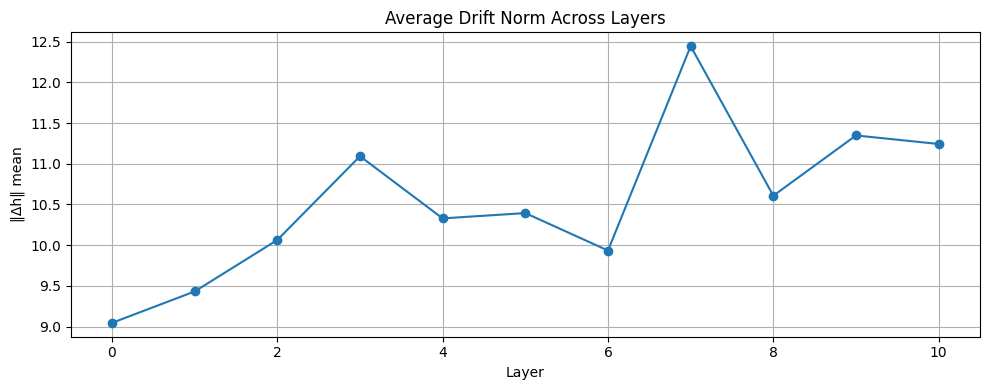

Jacobian rank (final token, projected): 48


In [195]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        embeddings = torch.cat([self.transformer.wte[i](idx)  for i in range(self.n_head)], dim=-1)
        embeddings = embeddings + pos_emb
        x = self.transformer.drop(embeddings)
        x_orig = x.clone()
        for stage in self.transformer.h:  # stages are ExplorerEngineerStage
          x = stage(x, x_orig)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss
'''


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # token + pos emb
    x = model.transformer.wte(tok)

    layers = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    tok_emb = model.transformer.wte(tok)
    emb = tok_emb

    def forward_emb(x):
        for block in model.transformer.h:
            x = block(x)             # time shrinks each block
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [174]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    x = model.transformer.wte(tok)

    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, tok_emb.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [175]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


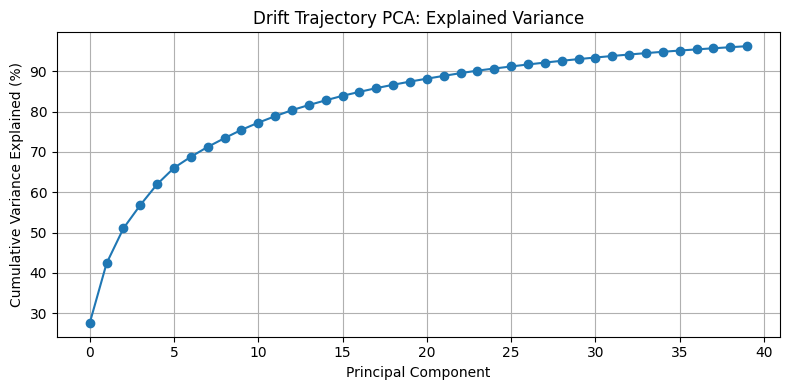

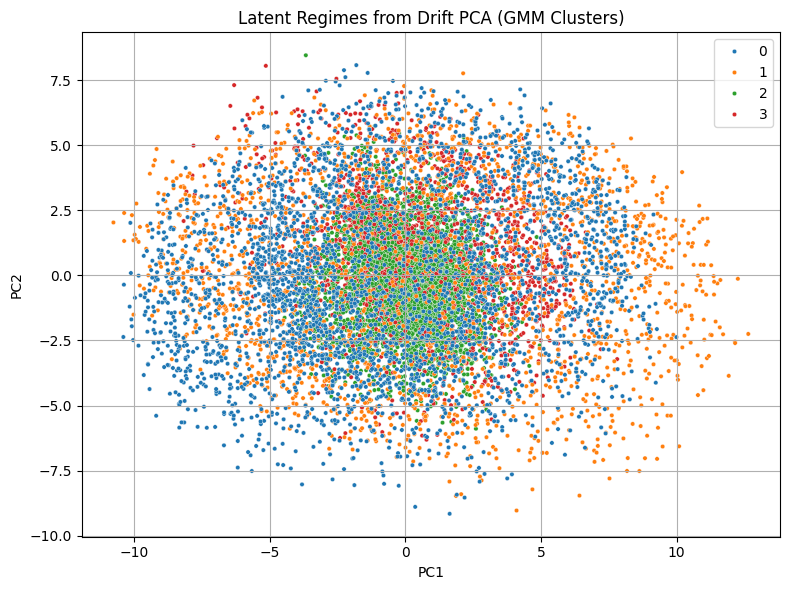

In [287]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)


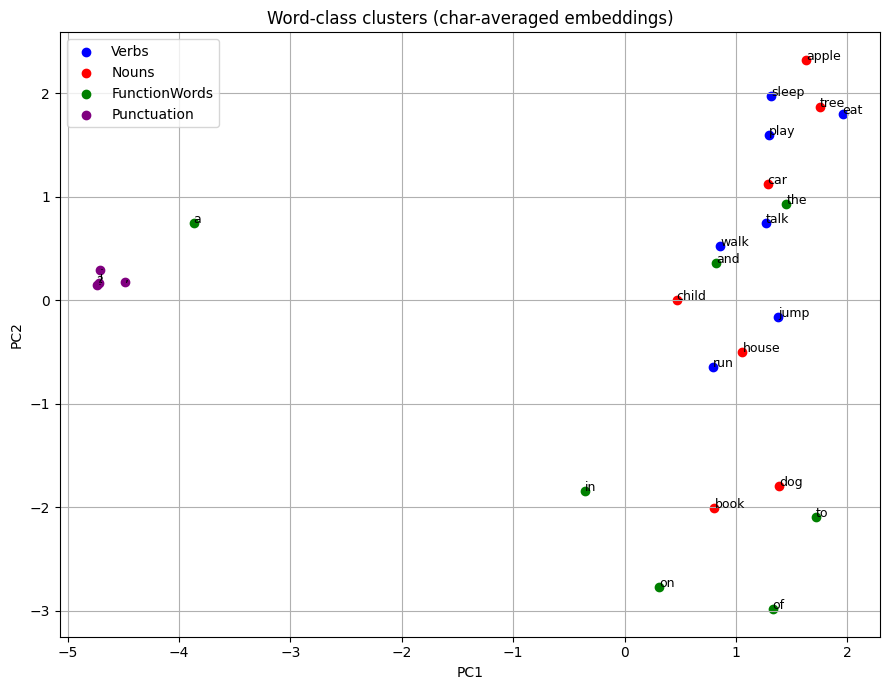

In [288]:
import torch, pickle, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ---------- load vocab ----------
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# ---------- model bits ----------
device = next(model.parameters()).device
model.eval()                      # <— turn off dropout everywhere
wte = model.transformer.wte
wte.eval()

@torch.no_grad()
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if len(ids) < 2:              # ← need ≥2 chars for HailFire geometry
        return None
    with torch.no_grad():
        t = torch.tensor(ids, device=device).unsqueeze(0)      # [1, T]
        emb = model.transformer.wte(t).mean(dim=1).squeeze(0)                    # (d,)
        return emb.cpu().numpy()

# ---------- categories ----------
categories = {
    "Verbs":        ["play","run","eat","sleep","jump","talk","walk"],
    "Nouns":        ["dog","tree","car","book","child","house","apple"],
    "FunctionWords":["the","and","in","on","to","of","a   "],
    "Punctuation":  [".    ",",    ","!    ","?    "],
}

# ---------- gather ----------
vecs, labels, words = [], [], []
for cat, wl in categories.items():
    for w in wl:
        v = get_char_embedding(w)
        if v is not None:
            vecs.append(v)
            labels.append(cat)
            words.append(w)

vecs = np.stack(vecs)             # ← now guaranteed rectangular

# ---------- PCA ----------
proj = PCA(n_components=2).fit_transform(vecs)

# ---------- plot ----------
colors = dict(Verbs="blue", Nouns="red",
              FunctionWords="green", Punctuation="purple")

plt.figure(figsize=(9,7))
for cat in categories:
    idx = [i for i,l in enumerate(labels) if l==cat]
    plt.scatter(proj[idx,0], proj[idx,1], label=cat, color=colors[cat])
    for i in idx:
        plt.text(proj[i,0], proj[i,1], words[i], fontsize=9)

plt.title("Word-class clusters (char-averaged embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


In [258]:
file_path = 'simple_model.pth'

# 3. Save the model's state_dict
torch.save(model.state_dict(), file_path)